# Mutual Information (synthetic)

Эксперименты с оценкой энтропии для синтетических данных.

# Преамбула

## Библиотеки

### Tensorflow

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

tfds.disable_progress_bar()
tf.enable_v2_behavior()

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices()

2.5.0
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Math, Numpy, Scipy, Pandas

In [2]:
import math
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.linalg as spl
import pandas as pd

### Matplotlib, Seaborn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Sklearn

In [4]:
# Деревья.
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

# Метрика.
from sklearn.metrics import pairwise_distances_argmin_min

# Метод главных компонент.
from sklearn.decomposition import PCA

# Выбор модели по кросс-валидации (поиск по сетке).
from sklearn.model_selection import GridSearchCV

### Joblib

In [5]:
from joblib import Parallel, delayed

n_jobs = 16

### OS, shutil, Json, CSV, copy

In [6]:
import os
import shutil
import json
import csv
import copy

## Вспомогательное

In [7]:
# Информация об опыте.
info = dict()

In [8]:
def normalize_uint8(data, label):
    """Нормализация: `uint8` -> `float32`."""
    return tf.cast(data, tf.float32) / 255.0, label

In [9]:
def imshow_array(array):
    """Отображение массива нормированных пикселей."""
    plt.axis('off')
    plt.imshow((255.0 * array).astype(np.uint8), cmap=plt.get_cmap("gray"), vmin=0, vmax=255)

In [10]:
def dataset_Y_to_X(X, Y):
    """Поменять у датасета пары (X, Y) на (X, X) (нужно, например, для обучения автоэнкодера)."""
    return X, X

In [11]:
def concave_loss(y_true, y_pred):
    """Вогнутая функция потерь, дающая более четкие изображения при обучении."""
    delta = tf.keras.backend.abs(y_true - y_pred)
    squared = tf.keras.backend.square(y_true - y_pred)
    return tf.keras.backend.mean(delta - 0.5 * squared, axis=-1)

## Google Drive

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

## Путь к папке с данными

In [13]:
#path = "/content/drive/My Drive/Information_v2/"
path = os.path.abspath(os.getcwd()) + "/data/"

# Синтетические данные

Для первоначальных экспериментов данные синтезируются путем сэмплирования точек из некоторого распределения с последующим отображением на некоторое многообразие.

In [14]:
dataset_dim_1 = 32 # Размерность данных 1.
latent_dim_1  = 2  # Реальная (скрытая) размерность данных 1.

dataset_dim_2 = 32 # Размерность данных 2.
latent_dim_2  = 2  # Реальная (скрытая) размерность данных 2.

final_noize_stdev = 0.0 # Стандартное отклонение шума, складываемого с выходом функции.
samples_number = 60000 # Размер выборки.
tests_number   = 10000 # Размер тестовой выборки.

In [15]:
experiments_path = path + "mutual_information/synthetic/"

In [16]:
%run Miscellaneous.ipynb

### Выбор случайной величины и отображения

In [17]:
np.random.seed(42)

In [18]:
random_variable_1 = One_Ring(less_rad = 3.0 * np.pi, bigg_rad = 4.0 * np.pi)
random_variable_2 = One_Ring(less_rad = 3.0 * np.pi, bigg_rad = 4.0 * np.pi)
#rv_id_ensemble([sps.uniform(0.0, 2.0 * np.pi), sps.uniform(0.0, 2.0 * np.pi)])

In [19]:
mapping_1 = mapping_ensemble([mapping_segmented([mapping_circle()] * 8, [(np.pi * i, np.pi * (i+1)) for i in range(-4,4)]),
                              mapping_segmented([mapping_circle()] * 8, [(np.pi * i, np.pi * (i+1)) for i in range(-4,4)])])

mapping_2 = mapping_ensemble([mapping_segmented([mapping_circle()] * 8, [(np.pi * i, np.pi * (i+1)) for i in range(-4,4)]),
                              mapping_segmented([mapping_circle()] * 8, [(np.pi * i, np.pi * (i+1)) for i in range(-4,4)])])

In [20]:
# Проверка входной размерности.
assert latent_dim_1 == mapping_1.input_dim
assert latent_dim_2 == mapping_2.input_dim

true_mutual_information = 0.0

### Генерация набора данных

In [21]:
# Матрица поворота и повышения размерности.
Q_1 = sps.ortho_group.rvs(dim = dataset_dim_1)
#Q_1 = np.eye(dataset_dim)
transform_1 = Q_1[:,:mapping_1.output_dim]

Q_2 = sps.ortho_group.rvs(dim = dataset_dim_2)
#Q_2 = np.eye(dataset_dim)
transform_2 = Q_2[:,:mapping_2.output_dim]

In [22]:
def get_samples(X, mapping, dataset_dim, transform_matrix, final_noize_stdev = 0.05):
    """
    Генерация набора данных.
    """

    # Данные во внутреннем представлении.
    samples_number = X.shape[0]
    
    # Отображение шума в пространство большей размерности.
    Y = np.zeros((samples_number, dataset_dim))
    noize = sps.norm(loc=0, scale=final_noize_stdev)
    for i in range(samples_number):
        Y[i] = transform_matrix @ mapping.map(X[i]) + noize.rvs(dataset_dim)
            
    return Y

In [23]:
X_1 = random_variable_1.rvs(samples_number)
X_2 = X_1#random_variable_2.rvs(samples_number)

T_1 = random_variable_1.rvs(tests_number)
T_2 = T_1#random_variable_2.rvs(tests_number)

samples_1 = get_samples(X_1, mapping_1, dataset_dim_1, transform_1, final_noize_stdev)
tests_1   = get_samples(T_1, mapping_1,   dataset_dim_1, transform_1, final_noize_stdev)

samples_2 = get_samples(X_2, mapping_2, dataset_dim_2, transform_2, final_noize_stdev)
tests_2   = get_samples(T_2, mapping_2,   dataset_dim_2, transform_2, final_noize_stdev)

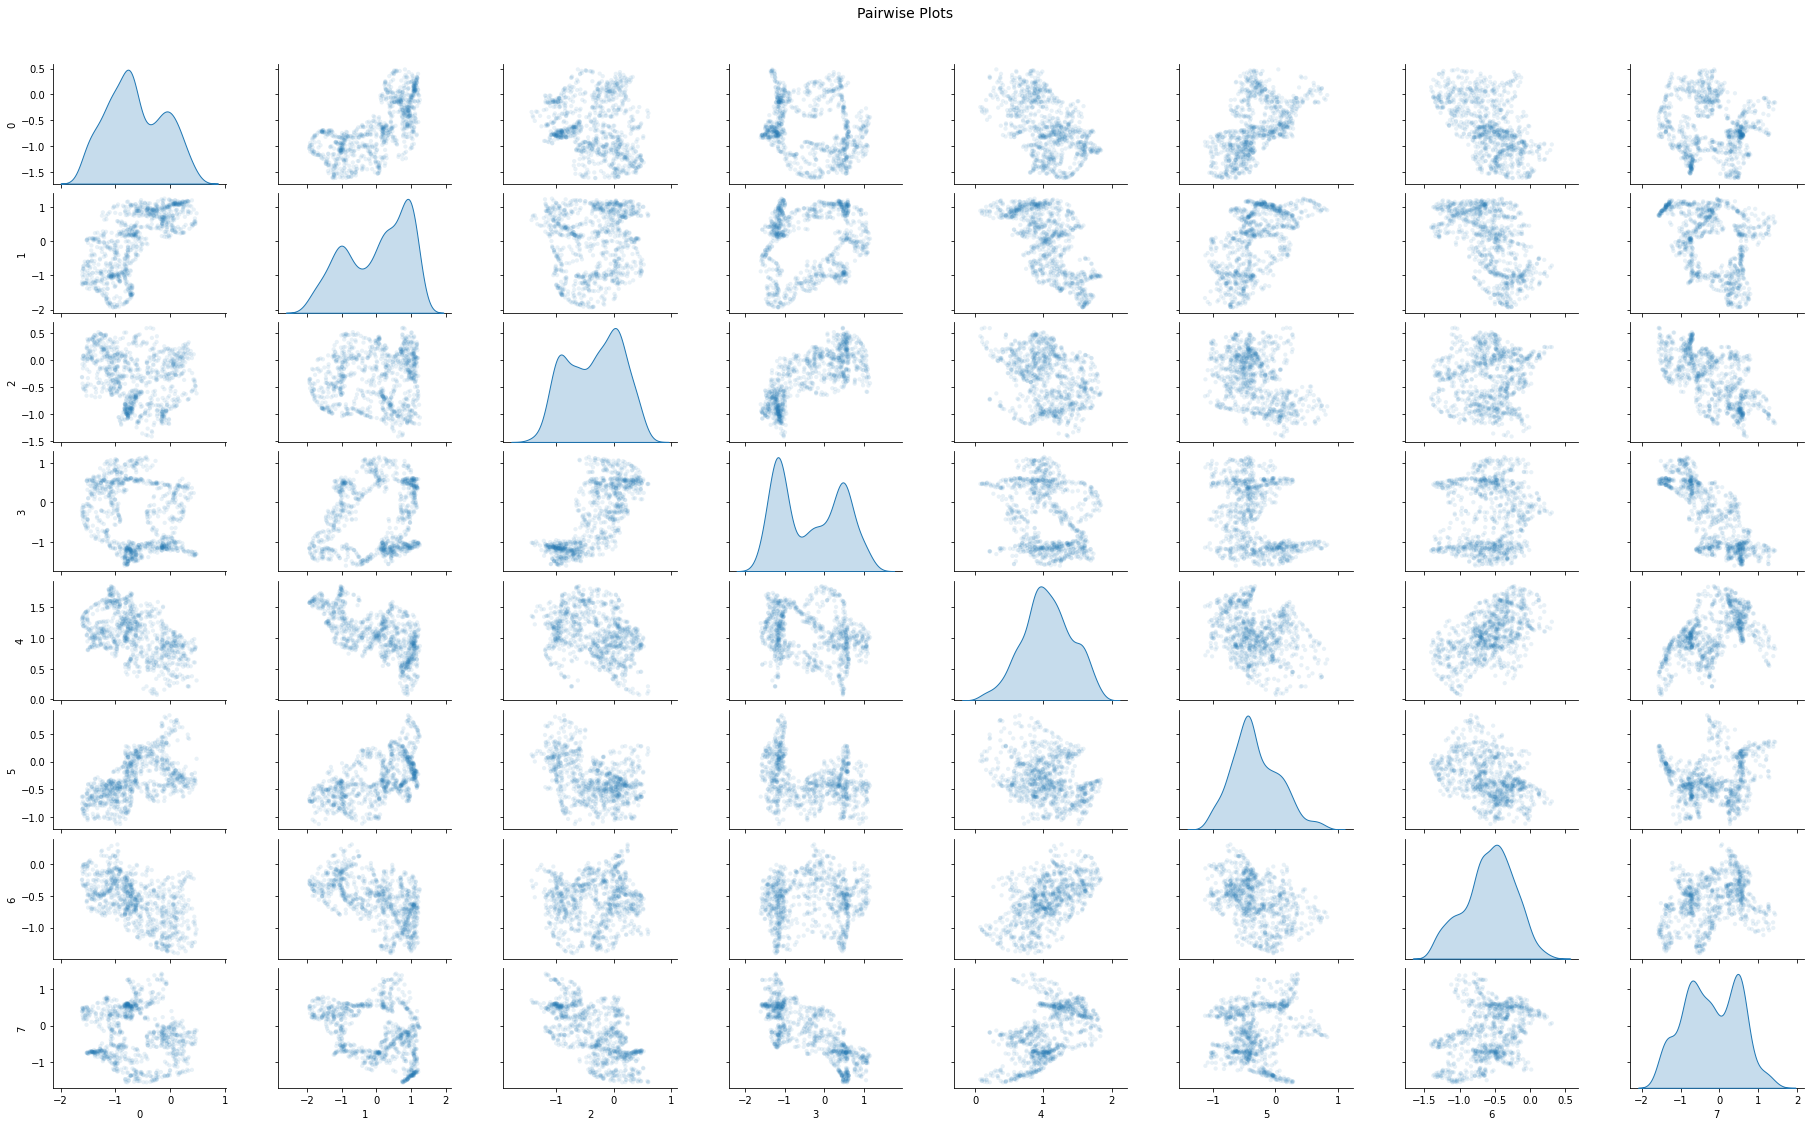

In [24]:
projected = np.array([samples_1[i][0:8] for i in range(1000)])

draw_pair_plot = True
if draw_pair_plot:
    pp = sns.pairplot(pd.DataFrame(projected), height = 2.0, aspect=1.6,
                      plot_kws=dict(edgecolor="k", linewidth=0.0, alpha=0.1, size=0.01, s=0.01),
                      diag_kind="kde", diag_kws=dict(shade=True))

    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('Pairwise Plots', fontsize=14)

### Путь к результатам

In [25]:
dataset_path = experiments_path + ("%.3e" % final_noize_stdev) + "/" + str(samples_number) + "_" + str(tests_number) + "/"

# Оценка энтропии

## Автокодировщик

Сжатие данных предлагается делать автокодировщиком.
Для архитектуры специфицируется только формат входных данных, а также размерность внутреннего представления (кодов).

In [26]:
# РАЗМЕРНОСТЬ КОДА.
# #
# #
 
codes_dim_1 = 2
codes_dim_2 = 2

# #
# #

In [27]:
# Число эпох для обучения.
epochs = 5000

In [28]:
full_path = dataset_path + "autoencoders/"
os.makedirs(full_path, exist_ok=True)

In [29]:
info['dataset_dim_1'] = dataset_dim_1
info['latent_dim_1'] = latent_dim_1

info['dataset_dim_2'] = dataset_dim_2
info['latent_dim_2'] = latent_dim_2

info['samples_number'] = samples_number
info['tests_number'] = tests_number

info['codes_dim_1'] = codes_dim_1
info['codes_dim_2'] = codes_dim_2
info['epochs'] = epochs

### Создание модели

In [30]:
def dense_autoencoder(shape_input, dimension):
    # Инициализация весов.
    init = tf.keras.initializers.RandomNormal(stddev = 0.02)

    # Входные данные генератора / выборки.
    input_layer = tf.keras.layers.Input(shape_input)
    next_layer = input_layer
    next_layer = tf.keras.layers.GaussianNoise(0.02)(next_layer)

    # 1 блок слоёв.
    next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(64, kernel_initializer = init),
                                                  power_iterations = 8)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # 2 блок слоёв.
    next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(32, kernel_initializer = init),
                                                  power_iterations = 8)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 3 блок слоёв.
    #next_layer = tf.keras.layers.Dense(8, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # Бутылочное горлышко.
    next_layer = tfa.layers.SpectralNormalization(tf.keras.layers.Dense(dimension),
                                                  power_iterations = 8)(next_layer)
    bottleneck = tf.keras.layers.Activation('tanh', name='bottleneck')(next_layer)

    # Модель кодировщика.
    encoder = tf.keras.Model(input_layer, bottleneck)

    # Начало модели декодировщика.
    input_code_layer = tf.keras.layers.Input((dimension))
    next_layer = input_code_layer

    # 3 блок слоёв.
    #next_layer = tf.keras.layers.Dense(8, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 2 блок слоёв.
    next_layer = tf.keras.layers.Dense(32, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # 1 блок слоёв.
    next_layer = tf.keras.layers.Dense(64, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 0 блок слоёв.
    next_layer = tf.keras.layers.Dense(shape_input[0])(next_layer) # Подразумевается, что вход - всё равно вектор.
    #next_layer = tf.keras.layers.Activation('tanh')(next_layer)
    
    output_layer = next_layer
    
    # Модель.
    decoder = tf.keras.models.Model(input_code_layer, output_layer) # Декодировщик.
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Компиляция модели.
    opt = tf.keras.optimizers.Adam(learning_rate = 5e-3)
    autoencoder.compile(loss = 'mse', optimizer = opt, loss_weights = [1.0])
    
    return encoder, decoder, autoencoder

### Загрузка модели

In [31]:
#encoder = tf.keras.models.load_model(full_path + "encoder.h5")
#decoder = tf.keras.models.load_model(full_path + "decoder.h5")
#autoencoder = autoencoder = tf.keras.Sequential([encoder, decoder])
#autoencoder.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss_weights = [1.0])

#with open(full_path + 'info.json', 'r') as fp:
#    info = json.load(fp)

In [32]:
encoder_1, decoder_1, autoencoder_1 = dense_autoencoder((dataset_dim_1,), codes_dim_1)
encoder_2, decoder_2, autoencoder_2 = dense_autoencoder((dataset_dim_2,), codes_dim_2)

#### Обучение 1

In [33]:
autoencoder_1.fit(samples_1, samples_1, epochs=epochs, validation_data=(tests_1, tests_1), batch_size=samples_number // 10)

Epoch 1/5000
10/10 [==============================] - 1s 14ms/step - loss: 0.4479 - val_loss: 0.3819
Epoch 2/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.3651 - val_loss: 0.3564
Epoch 3/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.3497 - val_loss: 0.3362
Epoch 4/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.3143 - val_loss: 0.2771
Epoch 5/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2547 - val_loss: 0.2392
Epoch 6/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2350 - val_loss: 0.2295
Epoch 7/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2252 - val_loss: 0.2184
Epoch 8/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2116 - val_loss: 0.2024
Epoch 9/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1963 - val_loss: 0.1899
Epoch 10/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1804 - val_loss: 0.167

10/10 [==============================] - 0s 4ms/step - loss: 0.0192 - val_loss: 0.0192
Epoch 83/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.0190
Epoch 84/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 85/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0193 - val_loss: 0.0187
Epoch 86/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0187 - val_loss: 0.0184
Epoch 87/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0192
Epoch 88/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0181
Epoch 89/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 90/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 91/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0178 - val_loss: 0.0177
Epoc

10/10 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 163/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 164/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 165/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 166/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 167/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 168/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 169/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 170/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 171/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 243/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 244/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 245/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 246/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 247/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 248/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 249/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 250/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 251/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 323/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 324/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 325/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 326/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 327/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 328/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 329/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 330/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 331/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 403/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 404/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 405/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 406/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 407/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 408/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 409/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 410/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 411/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 483/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 484/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 485/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 486/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 487/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 488/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 489/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 490/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 491/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 563/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 564/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 565/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 566/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 567/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 568/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 569/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 570/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 571/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.

10/10 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 643/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 644/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 645/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 646/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 647/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 648/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 649/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 650/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 651/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 723/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 724/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 725/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 726/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 727/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 728/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 729/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 730/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 731/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 803/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 804/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 805/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 806/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 807/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 808/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 809/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 810/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 811/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 883/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 884/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 885/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 886/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 887/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 888/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 889/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 890/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 891/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 963/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 964/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 965/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 966/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 967/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 968/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 969/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 970/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 971/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 1043/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 1044/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1045/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 1046/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1047/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 1048/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 1049/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 1050/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 1051/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 1122/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 1123/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1124/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 1125/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 1126/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 1127/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1128/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1129/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1130/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1201/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1202/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 1203/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1204/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1205/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 1206/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 1207/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 1208/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 1209/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 1280/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 1281/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 1282/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1283/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1284/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 1285/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1286/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1287/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 1288/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 1359/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 1360/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1361/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 1362/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1363/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1364/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 1365/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1366/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1367/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1438/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 1439/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1440/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1441/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1442/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 1443/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 1444/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1445/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1446/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 1517/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 1518/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 1519/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 1520/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 1521/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1522/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1523/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 1524/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 1525/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1596/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 1597/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1598/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1599/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1600/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1601/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 1602/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 1603/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 1604/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 1675/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1676/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 1677/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1678/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1679/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 1680/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 1681/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 1682/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 1683/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1754/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1755/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 1756/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1757/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 1758/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1759/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 1760/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 1761/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1762/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val

10/10 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1833/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 1834/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 1835/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 1836/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 1837/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 1838/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1839/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1840/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 1841/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 1912/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1913/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 1914/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1915/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1916/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 1917/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 1918/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 1919/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 1920/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 1991/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1992/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.9153e-04
Epoch 1993/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 1994/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1995/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 1996/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 1997/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1998/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.8683e-04
Epoch 1999/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.00

10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2070/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 2071/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2072/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 8.8438e-04
Epoch 2073/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2074/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 8.7575e-04
Epoch 2075/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2076/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 9.0470e-04
Epoch 2077/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2078/5000
10/10 [==============================] - 0s 5ms/step - loss: 

10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.7708e-04
Epoch 2148/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2149/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.9990e-04
Epoch 2150/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 2151/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.1345e-04
Epoch 2152/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2153/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 2154/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2155/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 2156/5000
10/10 [==============================] - 0s 4ms/step - loss: 

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2226/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2227/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2228/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2229/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2230/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2231/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2232/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.7416e-04
Epoch 2233/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2234/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 -

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2304/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2305/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.3200e-04
Epoch 2306/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.5081e-04 - val_loss: 0.0010
Epoch 2307/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7913e-04 - val_loss: 8.7167e-04
Epoch 2308/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2309/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2310/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2311/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.4264e-04
Epoch 2312/5000
10/10 [==============================] - 0s 4ms/step 

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2382/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2383/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2384/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2385/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.8077e-04
Epoch 2386/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2387/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2388/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2389/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2390/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 -

Epoch 2459/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 2460/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 9.3767e-04
Epoch 2461/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2462/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2463/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 2464/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 2465/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2466/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.8288e-04
Epoch 2467/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.4734e-04
Epoch 2468/5000
10/10 [==============================] - 0s 4

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.2894e-04
Epoch 2537/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.5222e-04 - val_loss: 0.0012
Epoch 2538/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.6619e-04
Epoch 2539/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7219e-04 - val_loss: 9.4314e-04
Epoch 2540/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.3981e-04
Epoch 2541/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.6445e-04 - val_loss: 9.8321e-04
Epoch 2542/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2543/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2544/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2545/5000
10/10 [==============================] - 

10/10 [==============================] - 0s 4ms/step - loss: 9.8934e-04 - val_loss: 0.0012
Epoch 2614/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2615/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.7763e-04
Epoch 2616/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.4078e-04 - val_loss: 8.2369e-04
Epoch 2617/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7079e-04 - val_loss: 7.8145e-04
Epoch 2618/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2619/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 2620/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2621/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.9229e-04
Epoch 2622/5000
10/10 [==============================] - 0s 4

10/10 [==============================] - 0s 4ms/step - loss: 9.4961e-04 - val_loss: 7.9678e-04
Epoch 2691/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.6171e-04 - val_loss: 8.2397e-04
Epoch 2692/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.5458e-04 - val_loss: 7.2863e-04
Epoch 2693/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.2586e-04 - val_loss: 7.7620e-04
Epoch 2694/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 2695/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 2696/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 2697/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.9120e-04
Epoch 2698/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.4156e-04
Epoch 2699/5000
10/10 [==========================

Epoch 2767/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.9391e-04 - val_loss: 7.5958e-04
Epoch 2768/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4252e-04 - val_loss: 7.7889e-04
Epoch 2769/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1137e-04 - val_loss: 8.9443e-04
Epoch 2770/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 2771/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 2772/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.1726e-04
Epoch 2773/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.1454e-04
Epoch 2774/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1650e-04 - val_loss: 7.1073e-04
Epoch 2775/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.9902e-04 - val_loss: 7.1400e-04
Epoch 2776/5000
10/10 [==

10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2844/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2845/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.4183e-04
Epoch 2846/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7360e-04 - val_loss: 9.2278e-04
Epoch 2847/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.9598e-04 - val_loss: 0.0012
Epoch 2848/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 2849/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.2721e-04
Epoch 2850/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.6266e-04
Epoch 2851/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2852/5000
10/10 [==============================] - 0s 4ms/s

10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.8527e-04
Epoch 2920/5000
10/10 [==============================] - 0s 5ms/step - loss: 9.6030e-04 - val_loss: 8.6477e-04
Epoch 2921/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.0452e-04 - val_loss: 8.3779e-04
Epoch 2922/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.4361e-04 - val_loss: 9.1105e-04
Epoch 2923/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2924/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2925/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 2926/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7581e-04 - val_loss: 8.9428e-04
Epoch 2927/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 2928/5000
10/10 [==============================

10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 2996/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2997/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 8.6882e-04
Epoch 2998/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.5798e-04 - val_loss: 6.8239e-04
Epoch 2999/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1207e-04 - val_loss: 8.3225e-04
Epoch 3000/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.6591e-04 - val_loss: 7.2660e-04
Epoch 3001/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3002/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 9.7817e-04
Epoch 3003/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.8896e-04
Epoch 3004/5000
10/10 [==============================

10/10 [==============================] - 0s 4ms/step - loss: 9.8115e-04 - val_loss: 9.0676e-04
Epoch 3072/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.3151e-04
Epoch 3073/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 9.0272e-04
Epoch 3074/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 3075/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.3006e-04
Epoch 3076/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3077/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.5123e-04
Epoch 3078/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.1452e-04
Epoch 3079/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.8198e-04 - val_loss: 6.3942e-04
Epoch 3080/5000
10/10 [==============================

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.5410e-04
Epoch 3148/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.5568e-04 - val_loss: 7.3765e-04
Epoch 3149/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7113e-04 - val_loss: 0.0012
Epoch 3150/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3151/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3152/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.0634e-04
Epoch 3153/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.0355e-04 - val_loss: 8.2685e-04
Epoch 3154/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7011e-04 - val_loss: 8.1037e-04
Epoch 3155/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.3424e-04 - val_loss: 7.3155e-04
Epoch 3156/5000
10/10 [======================

Epoch 3223/5000
10/10 [==============================] - 0s 5ms/step - loss: 9.9887e-04 - val_loss: 9.7180e-04
Epoch 3224/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.0796e-04 - val_loss: 6.7742e-04
Epoch 3225/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.6216e-04 - val_loss: 6.9586e-04
Epoch 3226/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7966e-04 - val_loss: 7.1479e-04
Epoch 3227/5000
10/10 [==============================] - 0s 4ms/step - loss: 1.0000e-03 - val_loss: 0.0011
Epoch 3228/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.5704e-04
Epoch 3229/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3230/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.8508e-04 - val_loss: 9.1857e-04
Epoch 3231/5000
10/10 [==============================] - 0s 5ms/step - loss: 8.8493e-04 - val_loss: 9.0440e-04
Epoch 3232/5000
1

10/10 [==============================] - 0s 4ms/step - loss: 8.3889e-04 - val_loss: 7.6306e-04
Epoch 3299/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.6042e-04 - val_loss: 6.9401e-04
Epoch 3300/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.4069e-04 - val_loss: 0.0011
Epoch 3301/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.1423e-04
Epoch 3302/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.3828e-04
Epoch 3303/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.0941e-04 - val_loss: 6.5205e-04
Epoch 3304/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.6233e-04 - val_loss: 7.8690e-04
Epoch 3305/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4677e-04 - val_loss: 8.9212e-04
Epoch 3306/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.0379e-04
Epoch 3307/5000
10/10 [==========

10/10 [==============================] - 0s 4ms/step - loss: 8.7744e-04 - val_loss: 8.3917e-04
Epoch 3374/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1666e-04 - val_loss: 8.4468e-04
Epoch 3375/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.6371e-04 - val_loss: 9.1369e-04
Epoch 3376/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.0913e-04
Epoch 3377/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.3033e-04 - val_loss: 8.7399e-04
Epoch 3378/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.9690e-04 - val_loss: 9.0578e-04
Epoch 3379/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3380/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.9817e-04 - val_loss: 7.5501e-04
Epoch 3381/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7892e-04 - val_loss: 0.0011
Epoch 3382/5000
10/10 [==========

10/10 [==============================] - 0s 4ms/step - loss: 8.0312e-04 - val_loss: 8.2773e-04
Epoch 3449/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1572e-04 - val_loss: 7.4818e-04
Epoch 3450/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.9023e-04 - val_loss: 8.3084e-04
Epoch 3451/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3452/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.2337e-04
Epoch 3453/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.8134e-04 - val_loss: 6.7619e-04
Epoch 3454/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7912e-04 - val_loss: 7.4109e-04
Epoch 3455/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.6809e-04 - val_loss: 8.1298e-04
Epoch 3456/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.1221e-04
Epoch 3457/5000
10/10 [==========

10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 6.9901e-04
Epoch 3524/5000
10/10 [==============================] - 0s 5ms/step - loss: 8.2493e-04 - val_loss: 6.6170e-04
Epoch 3525/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7671e-04 - val_loss: 6.9432e-04
Epoch 3526/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5927e-04 - val_loss: 6.8662e-04
Epoch 3527/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.8415e-04 - val_loss: 9.2157e-04
Epoch 3528/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3529/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.5482e-04
Epoch 3530/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7837e-04 - val_loss: 6.3638e-04
Epoch 3531/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7969e-04 - val_loss: 0.0012
Epoch 3532/5000
10/10 [==============

10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.4091e-04
Epoch 3599/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.3220e-04 - val_loss: 8.0398e-04
Epoch 3600/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4151e-04 - val_loss: 7.4153e-04
Epoch 3601/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.1981e-04
Epoch 3602/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.6986e-04 - val_loss: 9.9769e-04
Epoch 3603/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.5922e-04
Epoch 3604/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.2710e-04 - val_loss: 8.6651e-04
Epoch 3605/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.6812e-04 - val_loss: 7.3211e-04
Epoch 3606/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.9725e-04 - val_loss: 7.2017e-04
Epoch 3607/5000
10/10 [======

10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 7.3508e-04
Epoch 3674/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.4058e-04 - val_loss: 7.1714e-04
Epoch 3675/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.6624e-04 - val_loss: 6.3623e-04
Epoch 3676/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7693e-04 - val_loss: 9.7738e-04
Epoch 3677/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.3236e-04 - val_loss: 9.7399e-04
Epoch 3678/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.8301e-04 - val_loss: 8.8714e-04
Epoch 3679/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.8824e-04 - val_loss: 6.9875e-04
Epoch 3680/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.8071e-04 - val_loss: 7.0234e-04
Epoch 3681/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4372e-04 - val_loss: 8.2628e-04
Epoch 3682/5000
10/10

10/10 [==============================] - 0s 4ms/step - loss: 7.4290e-04 - val_loss: 7.2910e-04
Epoch 3749/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.4702e-04 - val_loss: 8.2284e-04
Epoch 3750/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.5827e-04 - val_loss: 9.0350e-04
Epoch 3751/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3752/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 3753/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.7575e-04
Epoch 3754/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4145e-04 - val_loss: 6.8663e-04
Epoch 3755/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.2239e-04 - val_loss: 8.0676e-04
Epoch 3756/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7946e-04 - val_loss: 6.7791e-04
Epoch 3757/5000
10/10 [==============

10/10 [==============================] - 0s 4ms/step - loss: 7.6109e-04 - val_loss: 6.8513e-04
Epoch 3824/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.6156e-04 - val_loss: 7.9102e-04
Epoch 3825/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3826/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 8.6491e-04
Epoch 3827/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.6331e-04 - val_loss: 7.0451e-04
Epoch 3828/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1225e-04 - val_loss: 0.0010
Epoch 3829/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.5840e-04
Epoch 3830/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.2244e-04 - val_loss: 6.9204e-04
Epoch 3831/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.9284e-04 - val_loss: 6.8500e-04
Epoch 3832/5000
10/10 [==============

10/10 [==============================] - 0s 4ms/step - loss: 9.5591e-04 - val_loss: 0.0010
Epoch 3899/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.3314e-04 - val_loss: 8.6342e-04
Epoch 3900/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.6095e-04 - val_loss: 7.2301e-04
Epoch 3901/5000
10/10 [==============================] - 0s 5ms/step - loss: 8.8442e-04 - val_loss: 7.0148e-04
Epoch 3902/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.8734e-04 - val_loss: 6.9154e-04
Epoch 3903/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.4470e-04 - val_loss: 0.0011
Epoch 3904/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.5311e-04
Epoch 3905/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 8.8080e-04
Epoch 3906/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 7.3492e-04
Epoch 3907/5000
10/10 [==============

10/10 [==============================] - 0s 5ms/step - loss: 7.9991e-04 - val_loss: 7.9252e-04
Epoch 3974/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5766e-04 - val_loss: 6.6317e-04
Epoch 3975/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7386e-04 - val_loss: 0.0012
Epoch 3976/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.1818e-04
Epoch 3977/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7803e-04 - val_loss: 9.9808e-04
Epoch 3978/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.8201e-04
Epoch 3979/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1704e-04 - val_loss: 7.4528e-04
Epoch 3980/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5494e-04 - val_loss: 5.9987e-04
Epoch 3981/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5540e-04 - val_loss: 8.0830e-04
Epoch 3982/5000
10/10 [======

Epoch 4048/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.3219e-04 - val_loss: 5.7278e-04
Epoch 4049/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.1484e-04 - val_loss: 8.8018e-04
Epoch 4050/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.0517e-04
Epoch 4051/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4052/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.7303e-04 - val_loss: 6.5362e-04
Epoch 4053/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.3356e-04 - val_loss: 6.8206e-04
Epoch 4054/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4803e-04 - val_loss: 7.4453e-04
Epoch 4055/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4056/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.5815e-04 - val_loss: 8.7197e-04
Epoch 4057/5000
10/10

Epoch 4123/5000
10/10 [==============================] - 0s 5ms/step - loss: 8.6524e-04 - val_loss: 7.1165e-04
Epoch 4124/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7291e-04 - val_loss: 6.3658e-04
Epoch 4125/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.2732e-04 - val_loss: 5.9266e-04
Epoch 4126/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7638e-04 - val_loss: 0.0012
Epoch 4127/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4128/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4129/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.9881e-04 - val_loss: 6.8838e-04
Epoch 4130/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.3502e-04 - val_loss: 5.9623e-04
Epoch 4131/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.0291e-04 - val_loss: 8.4874e-04
Epoch 4132/5000
10/10

10/10 [==============================] - 0s 4ms/step - loss: 8.5134e-04 - val_loss: 9.0166e-04
Epoch 4199/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 7.7269e-04
Epoch 4200/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4623e-04 - val_loss: 6.8187e-04
Epoch 4201/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.3686e-04 - val_loss: 6.5147e-04
Epoch 4202/5000
10/10 [==============================] - 0s 4ms/step - loss: 6.8621e-04 - val_loss: 6.6903e-04
Epoch 4203/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1506e-04 - val_loss: 9.1899e-04
Epoch 4204/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.6374e-04 - val_loss: 0.0012
Epoch 4205/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 9.8383e-04
Epoch 4206/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 7.6157e-04
Epoch 4207/5000
10/10 [==========

10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 4274/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 8.4983e-04
Epoch 4275/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.2565e-04 - val_loss: 9.6993e-04
Epoch 4276/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4277/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.4734e-04 - val_loss: 7.1939e-04
Epoch 4278/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.2515e-04 - val_loss: 5.3680e-04
Epoch 4279/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.0154e-04 - val_loss: 5.9763e-04
Epoch 4280/5000
10/10 [==============================] - 0s 4ms/step - loss: 6.8773e-04 - val_loss: 6.2861e-04
Epoch 4281/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7909e-04 - val_loss: 9.0518e-04
Epoch 4282/5000
10/10 [==============

10/10 [==============================] - 0s 4ms/step - loss: 9.2107e-04 - val_loss: 6.8382e-04
Epoch 4349/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.9575e-04 - val_loss: 7.6359e-04
Epoch 4350/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.3889e-04 - val_loss: 7.5279e-04
Epoch 4351/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4352/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 6.7755e-04
Epoch 4353/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.4862e-04 - val_loss: 6.8873e-04
Epoch 4354/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1323e-04 - val_loss: 7.1481e-04
Epoch 4355/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.4133e-04 - val_loss: 6.5027e-04
Epoch 4356/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 9.5596e-04
Epoch 4357/5000
10/10 [==========

10/10 [==============================] - 0s 4ms/step - loss: 7.9959e-04 - val_loss: 7.6888e-04
Epoch 4424/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5088e-04 - val_loss: 6.8038e-04
Epoch 4425/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4426/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4427/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 7.2352e-04
Epoch 4428/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5703e-04 - val_loss: 5.5669e-04
Epoch 4429/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.8120e-04 - val_loss: 8.1845e-04
Epoch 4430/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.0506e-04 - val_loss: 7.0661e-04
Epoch 4431/5000
10/10 [==============================] - 0s 5ms/step - loss: 8.0542e-04 - val_loss: 6.2419e-04
Epoch 4432/5000
10/10 [==============

Epoch 4498/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.5693e-04
Epoch 4499/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 6.4351e-04
Epoch 4500/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1531e-04 - val_loss: 6.7205e-04
Epoch 4501/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1157e-04 - val_loss: 9.4990e-04
Epoch 4502/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.3251e-04 - val_loss: 7.9028e-04
Epoch 4503/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.2011e-04 - val_loss: 8.2340e-04
Epoch 4504/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7781e-04 - val_loss: 7.0825e-04
Epoch 4505/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.2467e-04 - val_loss: 6.3856e-04
Epoch 4506/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5020e-04 - val_loss: 5.9749e-04
Epoch 450

10/10 [==============================] - 0s 5ms/step - loss: 8.1591e-04 - val_loss: 6.6043e-04
Epoch 4573/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.0910e-04 - val_loss: 8.4170e-04
Epoch 4574/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.2098e-04 - val_loss: 9.2923e-04
Epoch 4575/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.8424e-04
Epoch 4576/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.3468e-04 - val_loss: 6.8796e-04
Epoch 4577/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.7762e-04 - val_loss: 7.8295e-04
Epoch 4578/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.6096e-04 - val_loss: 5.4250e-04
Epoch 4579/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.2355e-04 - val_loss: 7.0888e-04
Epoch 4580/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.6461e-04 - val_loss: 5.8983e-04
Epoch 4581/5000
10/10

10/10 [==============================] - 0s 4ms/step - loss: 7.4862e-04 - val_loss: 6.1791e-04
Epoch 4647/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.2898e-04 - val_loss: 7.1257e-04
Epoch 4648/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.2065e-04 - val_loss: 0.0014
Epoch 4649/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4650/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1442e-04 - val_loss: 8.2223e-04
Epoch 4651/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1005e-04 - val_loss: 6.0022e-04
Epoch 4652/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.1993e-04 - val_loss: 8.7824e-04
Epoch 4653/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.0678e-04 - val_loss: 8.0153e-04
Epoch 4654/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5361e-04 - val_loss: 6.9631e-04
Epoch 4655/5000
10/10 [======

10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4721/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1954e-04 - val_loss: 6.5442e-04
Epoch 4722/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.8581e-04 - val_loss: 6.1726e-04
Epoch 4723/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.2071e-04 - val_loss: 0.0011
Epoch 4724/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.9241e-04 - val_loss: 6.2060e-04
Epoch 4725/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.3029e-04 - val_loss: 6.7221e-04
Epoch 4726/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.2669e-04 - val_loss: 0.0013
Epoch 4727/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 7.4444e-04
Epoch 4728/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1635e-04 - val_loss: 8.6940e-04
Epoch 4729/5000
10/10 [==============

10/10 [==============================] - 0s 4ms/step - loss: 6.5217e-04 - val_loss: 6.0382e-04
Epoch 4795/5000
10/10 [==============================] - 0s 4ms/step - loss: 6.6668e-04 - val_loss: 6.4255e-04
Epoch 4796/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.3829e-04 - val_loss: 7.6887e-04
Epoch 4797/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4798/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.6641e-04
Epoch 4799/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.6338e-04
Epoch 4800/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.0334e-04 - val_loss: 6.7784e-04
Epoch 4801/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.8832e-04 - val_loss: 6.0446e-04
Epoch 4802/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.7357e-04 - val_loss: 8.0435e-04
Epoch 4803/5000
10/10 [==========

10/10 [==============================] - 0s 4ms/step - loss: 7.6899e-04 - val_loss: 9.2570e-04
Epoch 4869/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 6.3930e-04
Epoch 4870/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.9890e-04 - val_loss: 6.2144e-04
Epoch 4871/5000
10/10 [==============================] - 0s 4ms/step - loss: 6.9576e-04 - val_loss: 6.8925e-04
Epoch 4872/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.3170e-04 - val_loss: 6.5551e-04
Epoch 4873/5000
10/10 [==============================] - 0s 4ms/step - loss: 9.1434e-04 - val_loss: 0.0012
Epoch 4874/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.7839e-04
Epoch 4875/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 9.7190e-04
Epoch 4876/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5883e-04 - val_loss: 6.3427e-04
Epoch 4877/5000
10/10 [==========

10/10 [==============================] - 0s 4ms/step - loss: 8.8346e-04 - val_loss: 7.4420e-04
Epoch 4943/5000
10/10 [==============================] - 0s 5ms/step - loss: 7.7963e-04 - val_loss: 6.7850e-04
Epoch 4944/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4271e-04 - val_loss: 7.0629e-04
Epoch 4945/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.4238e-04 - val_loss: 6.9326e-04
Epoch 4946/5000
10/10 [==============================] - 0s 4ms/step - loss: 8.5045e-04 - val_loss: 7.2506e-04
Epoch 4947/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.8084e-04 - val_loss: 7.7215e-04
Epoch 4948/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.0702e-04 - val_loss: 6.2428e-04
Epoch 4949/5000
10/10 [==============================] - 0s 4ms/step - loss: 7.5710e-04 - val_loss: 7.0272e-04
Epoch 4950/5000
10/10 [==============================] - 0s 4ms/step - loss: 6.9508e-04 - val_loss: 8.4252e-04
Epoch 4951/5000
1

In [34]:
autoencoder_1.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss_weights = [1.0])

In [35]:
autoencoder_1.fit(samples_1, samples_1, epochs=1000, validation_data=(tests_1, tests_1), batch_size=samples_number)

Epoch 1/1000
1/1 [==============================] - 0s 431ms/step - loss: 6.6133e-04 - val_loss: 0.0099
Epoch 2/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0100 - val_loss: 0.0013
Epoch 3/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 5/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 7/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 8.7083e-04
Epoch 8/1000
1/1 [==============================] - 0s 24ms/step - loss: 9.6080e-04 - val_loss: 0.0021
Epoch 9/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - val_loss: 0.0

Epoch 78/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9362e-04 - val_loss: 4.1244e-04
Epoch 79/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9253e-04 - val_loss: 4.1177e-04
Epoch 80/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9294e-04 - val_loss: 4.1146e-04
Epoch 81/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9171e-04 - val_loss: 4.1151e-04
Epoch 82/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9303e-04 - val_loss: 4.1142e-04
Epoch 83/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9283e-04 - val_loss: 4.1109e-04
Epoch 84/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.9150e-04 - val_loss: 4.1092e-04
Epoch 85/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.9229e-04 - val_loss: 4.1103e-04
Epoch 86/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9139e-04 - val_loss: 4.1106e-04
Epoch 87/1000
1/1 [=========

1/1 [==============================] - 0s 24ms/step - loss: 4.8899e-04 - val_loss: 4.0859e-04
Epoch 153/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8924e-04 - val_loss: 4.0856e-04
Epoch 154/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8892e-04 - val_loss: 4.0855e-04
Epoch 155/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8953e-04 - val_loss: 4.0856e-04
Epoch 156/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8928e-04 - val_loss: 4.0848e-04
Epoch 157/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8803e-04 - val_loss: 4.0856e-04
Epoch 158/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8855e-04 - val_loss: 4.0855e-04
Epoch 159/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8819e-04 - val_loss: 4.0848e-04
Epoch 160/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.8914e-04 - val_loss: 4.0855e-04
Epoch 161/1000
1/1 [==============

1/1 [==============================] - 0s 25ms/step - loss: 4.8796e-04 - val_loss: 4.0773e-04
Epoch 228/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8795e-04 - val_loss: 4.0744e-04
Epoch 229/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8759e-04 - val_loss: 4.0743e-04
Epoch 230/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8731e-04 - val_loss: 4.0744e-04
Epoch 231/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8670e-04 - val_loss: 4.0729e-04
Epoch 232/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8755e-04 - val_loss: 4.0736e-04
Epoch 233/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8773e-04 - val_loss: 4.0725e-04
Epoch 234/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8667e-04 - val_loss: 4.0729e-04
Epoch 235/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8795e-04 - val_loss: 4.0733e-04
Epoch 236/1000
1/1 [==============

1/1 [==============================] - 0s 25ms/step - loss: 4.8684e-04 - val_loss: 4.0664e-04
Epoch 303/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8541e-04 - val_loss: 4.0656e-04
Epoch 304/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8692e-04 - val_loss: 4.0649e-04
Epoch 305/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8566e-04 - val_loss: 4.0685e-04
Epoch 306/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8557e-04 - val_loss: 4.0684e-04
Epoch 307/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8648e-04 - val_loss: 4.0694e-04
Epoch 308/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8657e-04 - val_loss: 4.0655e-04
Epoch 309/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8514e-04 - val_loss: 4.0631e-04
Epoch 310/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8649e-04 - val_loss: 4.0645e-04
Epoch 311/1000
1/1 [==============

1/1 [==============================] - 0s 25ms/step - loss: 4.8444e-04 - val_loss: 4.0574e-04
Epoch 378/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8544e-04 - val_loss: 4.0566e-04
Epoch 379/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8488e-04 - val_loss: 4.0558e-04
Epoch 380/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8448e-04 - val_loss: 4.0582e-04
Epoch 381/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8499e-04 - val_loss: 4.0559e-04
Epoch 382/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8367e-04 - val_loss: 4.0527e-04
Epoch 383/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8404e-04 - val_loss: 4.0546e-04
Epoch 384/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8428e-04 - val_loss: 4.0554e-04
Epoch 385/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8489e-04 - val_loss: 4.0542e-04
Epoch 386/1000
1/1 [==============

1/1 [==============================] - 0s 25ms/step - loss: 4.8373e-04 - val_loss: 4.0455e-04
Epoch 453/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8381e-04 - val_loss: 4.0561e-04
Epoch 454/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8425e-04 - val_loss: 4.0668e-04
Epoch 455/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8543e-04 - val_loss: 4.0764e-04
Epoch 456/1000
1/1 [==============================] - 0s 26ms/step - loss: 4.8633e-04 - val_loss: 4.0852e-04
Epoch 457/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8687e-04 - val_loss: 4.0940e-04
Epoch 458/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.8780e-04 - val_loss: 4.0830e-04
Epoch 459/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8758e-04 - val_loss: 4.0678e-04
Epoch 460/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8548e-04 - val_loss: 4.0491e-04
Epoch 461/1000
1/1 [==============

1/1 [==============================] - 0s 24ms/step - loss: 4.8237e-04 - val_loss: 4.0353e-04
Epoch 528/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8129e-04 - val_loss: 4.0372e-04
Epoch 529/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8169e-04 - val_loss: 4.0380e-04
Epoch 530/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8303e-04 - val_loss: 4.0373e-04
Epoch 531/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8388e-04 - val_loss: 4.0457e-04
Epoch 532/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8396e-04 - val_loss: 4.0518e-04
Epoch 533/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8376e-04 - val_loss: 4.0700e-04
Epoch 534/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8550e-04 - val_loss: 4.0849e-04
Epoch 535/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8776e-04 - val_loss: 4.1078e-04
Epoch 536/1000
1/1 [==============

1/1 [==============================] - 0s 25ms/step - loss: 4.8429e-04 - val_loss: 4.0554e-04
Epoch 603/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8397e-04 - val_loss: 4.0647e-04
Epoch 604/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8473e-04 - val_loss: 4.0871e-04
Epoch 605/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8633e-04 - val_loss: 4.0968e-04
Epoch 606/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8862e-04 - val_loss: 4.1032e-04
Epoch 607/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8795e-04 - val_loss: 4.0725e-04
Epoch 608/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8652e-04 - val_loss: 4.0452e-04
Epoch 609/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8229e-04 - val_loss: 4.0254e-04
Epoch 610/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8048e-04 - val_loss: 4.0407e-04
Epoch 611/1000
1/1 [==============

1/1 [==============================] - 0s 25ms/step - loss: 4.8143e-04 - val_loss: 4.0364e-04
Epoch 678/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.8147e-04 - val_loss: 4.0376e-04
Epoch 679/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8210e-04 - val_loss: 4.0302e-04
Epoch 680/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8053e-04 - val_loss: 4.0213e-04
Epoch 681/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8101e-04 - val_loss: 4.0190e-04
Epoch 682/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.7993e-04 - val_loss: 4.0217e-04
Epoch 683/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8070e-04 - val_loss: 4.0310e-04
Epoch 684/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8088e-04 - val_loss: 4.0306e-04
Epoch 685/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8083e-04 - val_loss: 4.0311e-04
Epoch 686/1000
1/1 [==============

1/1 [==============================] - 0s 25ms/step - loss: 4.8258e-04 - val_loss: 4.0631e-04
Epoch 753/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8358e-04 - val_loss: 4.0832e-04
Epoch 754/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8628e-04 - val_loss: 4.1509e-04
Epoch 755/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.9233e-04 - val_loss: 4.2082e-04
Epoch 756/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9886e-04 - val_loss: 4.2784e-04
Epoch 757/1000
1/1 [==============================] - 0s 23ms/step - loss: 5.0392e-04 - val_loss: 4.2928e-04
Epoch 758/1000
1/1 [==============================] - 0s 24ms/step - loss: 5.0718e-04 - val_loss: 4.2966e-04
Epoch 759/1000
1/1 [==============================] - 0s 25ms/step - loss: 5.0658e-04 - val_loss: 4.2066e-04
Epoch 760/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.9965e-04 - val_loss: 4.1415e-04
Epoch 761/1000
1/1 [==============

1/1 [==============================] - 0s 24ms/step - loss: 4.8691e-04 - val_loss: 4.0953e-04
Epoch 828/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8705e-04 - val_loss: 4.0780e-04
Epoch 829/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8505e-04 - val_loss: 4.0633e-04
Epoch 830/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8336e-04 - val_loss: 4.0459e-04
Epoch 831/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8282e-04 - val_loss: 4.0591e-04
Epoch 832/1000
1/1 [==============================] - 0s 26ms/step - loss: 4.8285e-04 - val_loss: 4.0818e-04
Epoch 833/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.8612e-04 - val_loss: 4.0956e-04
Epoch 834/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8698e-04 - val_loss: 4.0866e-04
Epoch 835/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8602e-04 - val_loss: 4.0678e-04
Epoch 836/1000
1/1 [==============

1/1 [==============================] - 0s 24ms/step - loss: 4.8025e-04 - val_loss: 4.0267e-04
Epoch 903/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8022e-04 - val_loss: 4.0160e-04
Epoch 904/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7871e-04 - val_loss: 4.0043e-04
Epoch 905/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7757e-04 - val_loss: 3.9910e-04
Epoch 906/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7631e-04 - val_loss: 3.9910e-04
Epoch 907/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7646e-04 - val_loss: 4.0000e-04
Epoch 908/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7783e-04 - val_loss: 4.0205e-04
Epoch 909/1000
1/1 [==============================] - 0s 27ms/step - loss: 4.7843e-04 - val_loss: 4.0281e-04
Epoch 910/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7994e-04 - val_loss: 4.0354e-04
Epoch 911/1000
1/1 [==============

1/1 [==============================] - 0s 24ms/step - loss: 4.7822e-04 - val_loss: 4.0204e-04
Epoch 978/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.7823e-04 - val_loss: 4.0299e-04
Epoch 979/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.7915e-04 - val_loss: 4.0236e-04
Epoch 980/1000
1/1 [==============================] - 0s 23ms/step - loss: 4.7957e-04 - val_loss: 4.0296e-04
Epoch 981/1000
1/1 [==============================] - 0s 26ms/step - loss: 4.7940e-04 - val_loss: 4.0259e-04
Epoch 982/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.8004e-04 - val_loss: 4.0353e-04
Epoch 983/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8000e-04 - val_loss: 4.0397e-04
Epoch 984/1000
1/1 [==============================] - 0s 24ms/step - loss: 4.8012e-04 - val_loss: 4.0615e-04
Epoch 985/1000
1/1 [==============================] - 0s 20ms/step - loss: 4.8272e-04 - val_loss: 4.0746e-04
Epoch 986/1000
1/1 [==============

#### Обучение 2

In [ ]:
autoencoder_2.fit(samples_2, samples_2, epochs=epochs, validation_data=(tests_2, tests_2), batch_size=samples_number // 10)

Epoch 1/5000
10/10 [==============================] - 1s 12ms/step - loss: 0.4580 - val_loss: 0.3872
Epoch 2/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.3658 - val_loss: 0.3395
Epoch 3/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.3105 - val_loss: 0.2604
Epoch 4/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2507 - val_loss: 0.2423
Epoch 5/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2369 - val_loss: 0.2340
Epoch 6/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2291 - val_loss: 0.2249
Epoch 7/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2178 - val_loss: 0.2114
Epoch 8/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2031 - val_loss: 0.1976
Epoch 9/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1928 - val_loss: 0.1920
Epoch 10/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1888 - val_loss: 0.188

10/10 [==============================] - 0s 4ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 83/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0167
Epoch 84/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 85/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 86/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 87/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0137
Epoch 88/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 89/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 90/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0143
Epoch 91/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0133
Epoc

10/10 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 163/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 164/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 165/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 166/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 167/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 168/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 169/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 170/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 171/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 243/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 244/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 245/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 246/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 247/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 248/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 249/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 250/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 251/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 323/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 324/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 325/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 326/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 327/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 328/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 329/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 330/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 331/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 403/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 404/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 405/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 406/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 407/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 408/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 409/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 410/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 411/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 483/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 484/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 485/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 486/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 487/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 488/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 489/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 490/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 491/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 563/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 564/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 565/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 566/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 567/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 568/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 569/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 570/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 571/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 643/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 644/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 645/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 646/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 647/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 648/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 649/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 650/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 651/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.

10/10 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 723/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 724/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 725/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 726/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 727/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 728/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 729/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 730/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 731/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 803/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 804/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 805/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 806/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 807/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 808/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 809/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 810/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 811/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.

10/10 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 883/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 884/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 885/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 886/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 887/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 888/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 889/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 890/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 891/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 963/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 964/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 965/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 966/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 967/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 968/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 969/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 970/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 971/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1043/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0038
Epoch 1044/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 1045/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1046/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 1047/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 1048/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1049/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 1050/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 1051/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 1122/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 1123/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 1124/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1125/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 1126/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 1127/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 1128/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 1129/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 1130/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 1201/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 1202/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1203/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1204/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1205/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 1206/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1207/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1208/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1209/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.0017 - val

In [ ]:
autoencoder_2.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss_weights = [1.0])

In [ ]:
autoencoder_2.fit(samples_2, samples_2, epochs=1000, validation_data=(tests_2, tests_2), batch_size=samples_number)

In [ ]:
# Сохранение моделей.
autoencoder_1.save(full_path + "autoencoder_1.h5")
encoder_1.save(full_path + "encoder_1.h5")
decoder_1.save(full_path + "decoder_1.h5")

autoencoder_2.save(full_path + "autoencoder_2.h5")
encoder_2.save(full_path + "encoder_2.h5")
decoder_2.save(full_path + "decoder_2.h5")

In [ ]:
# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp, indent=4)

### Получение кодов всех элементов набора данных

In [ ]:
codes_1 = np.array(encoder_1.predict(samples_1))
codes_2 = np.array(encoder_2.predict(samples_2))

In [ ]:
codes_12 = np.concatenate((codes_1, codes_2), 1)
codes_dim_12 = codes_dim_1 + codes_dim_2

In [ ]:
codes_pca_dim_1 = codes_dim_1
PCA_codes_1 = PCA(n_components=codes_pca_dim_1, whiten=True)
codes_pca_1 = np.array(PCA_codes_1.fit_transform(codes_1))

codes_pca_dim_2 = codes_dim_2
PCA_codes_2 = PCA(n_components=codes_pca_dim_2, whiten=True)
codes_pca_2 = np.array(PCA_codes_2.fit_transform(codes_2))

In [ ]:
codes_pca_dim_12 = codes_dim_12
PCA_codes_12 = PCA(n_components=codes_pca_dim_12, whiten=True)
codes_pca_12 = np.array(PCA_codes_12.fit_transform(codes_12))

In [ ]:
pp = sns.pairplot(pd.DataFrame(codes_pca_12[0:10000]), height = 2.0, aspect=1.6,
                      plot_kws=dict(edgecolor="k", linewidth=0.0, alpha=0.05, size=0.01, s=0.01),
                      diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots', fontsize=14)

### KDE для кодов

In [ ]:
# Загрузка параметров KDE.

#with open(full_path + 'info.json', 'r') as fp:
#    info = json.load(fp)

#kde_codes = KernelDensity(bandwidth=info['bandwidth'], kernel='gaussian')
#kde_codes.fit(codes_pca)

In [ ]:
def smart_gridsearch(begin, end, data, resolution = 7, rel_x_epsilon = 0.01, rtol = 0.001, n_jobs = 2, cv = 20):
    while True:
        grid = np.logspace(np.log10(begin), np.log10(end), resolution)
        print("Поиск по сетке: ", grid)
        params = {'bandwidth': grid}
        
        grid_search = GridSearchCV(KernelDensity(rtol = rtol, kernel='gaussian'), params, n_jobs = n_jobs, verbose = 10, cv = cv)
        grid_search.fit(data)
        
        if grid_search.best_index_ == 0:
            begin *= begin / end
            end = grid[1]
        elif grid_search.best_index_ == resolution - 1:
            end *= end / begin
            begin = grid[-2]
        else:
            begin = grid[grid_search.best_index_ - 1]
            end = grid[grid_search.best_index_ + 1]

            if end - begin < rel_x_epsilon * grid[grid_search.best_index_]:
                return grid_search 

In [ ]:
KDE_codes_1 = smart_gridsearch(0.05, 0.2, codes_pca_1, n_jobs = n_jobs).best_estimator_
KDE_codes_1.set_params(rtol = 0.0)
print(KDE_codes_1.get_params())

In [ ]:
KDE_codes_2 = smart_gridsearch(0.05, 0.2, codes_pca_2, n_jobs = n_jobs).best_estimator_
KDE_codes_2.set_params(rtol = 0.0)
print(KDE_codes_2.get_params())

In [ ]:
KDE_codes_12 = smart_gridsearch(0.05, 0.2, codes_pca_12, n_jobs = n_jobs).best_estimator_
KDE_codes_12.set_params(rtol = 0.0)
#KDE_codes_12 = KernelDensity(rtol = 0.0, bandwidth = max(KDE_codes_1.get_params()['bandwidth'], KDE_codes_2.get_params()['bandwidth']))
print(KDE_codes_12.get_params())

In [ ]:
info['bandwidth_1'] = KDE_codes_1.get_params()['bandwidth']
info['bandwidth_2'] = KDE_codes_2.get_params()['bandwidth']
info['bandwidth_12'] = KDE_codes_12.get_params()['bandwidth']

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp, indent=4)

## Подсчёт энтропии

In [ ]:
def _loo_step(bandwidth, samples, i):
    loo_samples = samples
    np.delete(loo_samples, i)
    
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(loo_samples)
    return kde.score_samples([samples[i]])[0]

In [ ]:
def entropy_leave_one_out_parallel(path, bandwidth, samples, n_jobs = 2, first_N = None, parts = 10, recover_saved = False):
    """
    Параллельное вычисление оценки энтропии методом убрать-один-элемент.
    """
    
    # Создание временных папок для сохранения прогресса.
    parts_path = path + "LOO_PARTS/"
    os.makedirs(parts_path, exist_ok=True)

    # Если дано first_N, энтропия будет оцениваться только на первых first_N элементах.
    N = 0
    if first_N is None:
        N = len(samples)
    else:
        N = first_N

    # Число частей и массив, их содержащий.
    N_per_part = N // parts
    log_probs = []

    # Восстанавливаем прогресс, если требуется.
    recovered_parts = 0
    if recover_saved:
        for filename in os.listdir(parts_path):
            if filename.endswith(".csv"):
                log_probs.append(np.loadtxt(parts_path + filename))
                recovered_parts += 1

    print("Восстановлено блоков данных: %d" % recovered_parts)

    # Подсчёт логарифма вероятности в точках.
    for part in range(recovered_parts, parts):
        log_probs.append(
            np.array(
                Parallel(n_jobs = n_jobs, verbose = 10, batch_size = 8)(
                    delayed(_loo_step)(bandwidth, samples, i) for i in range(part * N_per_part, min((part + 1) * N_per_part, N))
                )
            )
        )
        np.savetxt(parts_path + str(part) + ".csv", log_probs[part], delimiter="\n")
    
    # Объединение в один массив.
    log_prob = np.concatenate(log_probs)

    # Суммирование и нахождение стандартного отклонения.
    average = -math.fsum(log_prob) / N    
    squared_deviations = np.zeros(N)
    for i in range(N):
        squared_deviations[i] = (log_prob[i] - average)**2
    standard_deviation = np.sqrt(math.fsum(squared_deviations) / (N * (N - 1)))
    
    # Удаление временных файлов.
    shutil.rmtree(parts_path)
        
    return average, standard_deviation

In [ ]:
latent_entropy_1, latent_entropy_error_1 = entropy_leave_one_out_parallel(full_path, KDE_codes_1.get_params()['bandwidth'], codes_pca_1, n_jobs = n_jobs, recover_saved = False)
print("LH1: %f, errLH1: %f" % (latent_entropy_1, latent_entropy_error_1))

In [ ]:
latent_entropy_2, latent_entropy_error_2 = entropy_leave_one_out_parallel(full_path, KDE_codes_2.get_params()['bandwidth'], codes_pca_2, n_jobs = n_jobs, recover_saved = False)
print("LH2: %f, errLH2: %f" % (latent_entropy_2, latent_entropy_error_2))

In [ ]:
latent_entropy_12, latent_entropy_error_12 = entropy_leave_one_out_parallel(full_path, KDE_codes_12.get_params()['bandwidth'], codes_pca_12, n_jobs = n_jobs, recover_saved = False)
print("LH12: %f, errLH12: %f" % (latent_entropy_12, latent_entropy_error_12))

In [ ]:
info['latent_entropy_1'] = latent_entropy_1
info['latent_entropy_error_1'] = latent_entropy_error_1

info['latent_entropy_2'] = latent_entropy_2
info['latent_entropy_error_2'] = latent_entropy_error_2

info['latent_entropy_12'] = latent_entropy_12
info['latent_entropy_error_12'] = latent_entropy_error_12

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp, indent=4)

In [ ]:
# Коэффициент растяжения при денормализации.
PCA_codes_defc_1 = np.abs(np.linalg.det( PCA_codes_1.inverse_transform(np.eye(codes_pca_dim_1)) -
                                         PCA_codes_1.inverse_transform(np.zeros((codes_pca_dim_1, codes_pca_dim_1))) ))

PCA_codes_defc_2 = np.abs(np.linalg.det( PCA_codes_2.inverse_transform(np.eye(codes_pca_dim_2)) -
                                         PCA_codes_2.inverse_transform(np.zeros((codes_pca_dim_2, codes_pca_dim_2))) ))
                                                                       
PCA_codes_defc_12 = np.abs(np.linalg.det( PCA_codes_12.inverse_transform(np.eye(codes_pca_dim_12)) -
                                          PCA_codes_12.inverse_transform(np.zeros((codes_pca_dim_12, codes_pca_dim_12))) ))

In [ ]:
# Соответствующая энтропия.
PCA_codes_transform_entropy_1 = np.log(PCA_codes_defc_1)
PCA_codes_transform_entropy_2 = np.log(PCA_codes_defc_2)
PCA_codes_transform_entropy_12 = np.log(PCA_codes_defc_12)

print("PCA_TH1: %f" % (PCA_codes_transform_entropy_1))
print("PCA_TH2: %f" % (PCA_codes_transform_entropy_2))
print("PCA_TH12: %f" % (PCA_codes_transform_entropy_12))

In [ ]:
info['PCA_codes_transform_entropy_1'] = PCA_codes_transform_entropy_1
info['PCA_codes_transform_entropy_2'] = PCA_codes_transform_entropy_2
info['PCA_codes_transform_entropy_12'] = PCA_codes_transform_entropy_12

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp, indent=4)

In [ ]:
# Итоговая оценка энтропии.
entropy_1 = latent_entropy_1 + PCA_codes_transform_entropy_1
entropy_error_1 = latent_entropy_error_1

entropy_2 = latent_entropy_1 + PCA_codes_transform_entropy_2
entropy_error_2 = latent_entropy_error_2

entropy_12 = latent_entropy_12 + PCA_codes_transform_entropy_12
entropy_error_12 = latent_entropy_error_12

print("H1: %f, errH1: %f\nH2: %f, errH2: %f\nH12: %f, errH12: %f" %
      (entropy_1, entropy_error_1, entropy_2, entropy_error_2, entropy_12, entropy_error_12))

In [ ]:
mutual_information = entropy_1 + entropy_2 - entropy_12
mutual_information_error = entropy_error_12 + entropy_error_1 + entropy_error_2

print("MI: %f, errMI: %f" % (mutual_information, mutual_information_error))

In [ ]:
info['entropy_1'] = entropy_1
info['entropy_error_1'] = entropy_error_1

info['entropy_2'] = entropy_2
info['entropy_error_2'] = entropy_error_2

info['entropy_12'] = entropy_12
info['entropy_error_12'] = entropy_error_12


info['mutual_information'] = mutual_information
info['mutual_information_error'] = mutual_information_error

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp, indent=4)